In [12]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os

# Importing Data

## Define Data Folders

In [2]:
parent_data_folder = "Y:/Downloads/tests/"
raw_test_name_1 = parent_data_folder + "Hat_1_2023-05-31_12--52--55"
raw_test_name_1 = raw_test_name_1 + ".csv"

raw_test_name_2 = parent_data_folder + "Hat_2_2023-05-31_12--52--55"
raw_test_name_2 = raw_test_name_2 + ".csv"


print(raw_test_name_1)
print(raw_test_name_2)

Y:/Downloads/tests/Hat_1_2023-05-31_12--52--55.csv
Y:/Downloads/tests/Hat_2_2023-05-31_12--52--55.csv


## Open and merge two DFs

In [4]:
import pandas as pd

# Define the chunk size
chunk_size = 50000 # Modify this value based on your need

# Initialize empty lists to hold the chunks from both files
chunks_file1 = []
chunks_file2 = []

# Read the first csv file in chunks
for chunk in pd.read_csv(raw_test_name_1, chunksize=chunk_size):
    chunks_file1.append(chunk)

# Read the second csv file in chunks
for chunk in pd.read_csv(raw_test_name_2, chunksize=chunk_size):
    chunks_file2.append(chunk)

# Concatenate all chunks from the first file
df1 = pd.concat(chunks_file1, axis=0)

# Concatenate all chunks from the second file
df2 = pd.concat(chunks_file2, axis=0)
df2 = df2.drop('time', axis=1)
df2 = df2.rename(columns={'value_1': 'value_3', 'value_2': 'value_4'})


# Merge the two dataframes
# Assuming that they can be merged on the index
data_frame = pd.concat([df1, df2], axis=1)

In [5]:
data_frame['time'] = pd.Series(range(len(data_frame))) / 10240
data_frame = data_frame.rename(columns={'value_1': 'HAT0_CH0', 'value_2': 'HAT0_CH1', 'value_3': 'HAT1_CH0', 'value_4': 'HAT1_CH1'})

## Creates a csv files with the combined data

In [189]:
#combined_test_name = re.sub("Hat_1", "Hat_Combined", raw_test_name_1)
#data_frame.to_csv(combined_test_name, index=False)

In [6]:
data_frame.head()

,time,HAT0_CH0,HAT0_CH1,HAT1_CH0,HAT1_CH1
0,0.000000,3.362311,1.947354,0.392176,-2.138897
1,0.000098,2.990163,0.287763,1.557017,-3.788048
2,0.000195,3.382346,-1.154630,0.765266,-5.112374
3,0.000293,2.951891,-1.588061,-4.724610,3.208980
4,0.000391,5.112546,-0.878573,-2.331163,1.964358


In [7]:
print(data_frame)

                time  HAT0_CH0  HAT0_CH1  HAT1_CH0  HAT1_CH1
0           0.000000  3.362311  1.947354  0.392176 -2.138897
1           0.000098  2.990163  0.287763  1.557017 -3.788048
2           0.000195  3.382346 -1.154630  0.765266 -5.112374
3           0.000293  2.951891 -1.588061 -4.724610  3.208980
4           0.000391  5.112546 -0.878573 -2.331163  1.964358
...              ...       ...       ...       ...       ...
10083541  984.720801  0.008753  0.008212       NaN       NaN
10083542  984.720898  0.002437  0.002101       NaN       NaN
10083543  984.720996 -0.005080 -0.005015       NaN       NaN
10083544  984.721094 -0.007207 -0.006928       NaN       NaN
10083545  984.721191 -0.010535 -0.010059       NaN       NaN

[10083546 rows x 5 columns]


## Shape into Dataframe

# Meta Validation

### Maximum, minimums and average

In [8]:
# Calculate the maximum, minimum, and average values
max_values = data_frame.max()
min_values = data_frame.min()
average_values = data_frame.mean()

# Create a DataFrame with the results
stats_df = pd.DataFrame({'Maximum': max_values, 'Minimum': min_values, 'Average': average_values})

# Round the values to 1 decimal place
stats_df_rounded = stats_df.round(1)

# Display the results in a tabular format
print(stats_df_rounded)

# Note: values of 0.0 indicate that - most likely - the channel was not used

          Maximum  Minimum  Average
time        984.7      0.0    492.4
HAT0_CH0      5.1     -5.1      0.0
HAT0_CH1      5.1     -5.1     -0.0
HAT1_CH0      5.1     -5.1      0.0
HAT1_CH1      5.1     -5.1      0.0


### Data Points & Recording Time

In [9]:
# Access the first column using its index and count the number of data points
#time_values = data_frame.iloc[:, 0]
time_values = data_frame["time"]
data_points_count = time_values.count()

# Workaround to account for files that don't start at 0 seconds
initial_recording_time = time_values.iloc[0]
final_recording_time = time_values.iloc[-1]
delta_recording_time = final_recording_time - initial_recording_time

print("Number of data points in the first column:", data_points_count)
print("Data was recorded for", round(delta_recording_time,2), "seconds")
print("Data was recorded for", round(delta_recording_time/60,2), "minutes")
print("Data was recorded for", round(delta_recording_time/3600,2), "hours")

Number of data points in the first column: 10083546
Data was recorded for 984.72 seconds
Data was recorded for 16.41 minutes
Data was recorded for 0.27 hours


### Sampling rate, Consistency and CV

In [10]:
# Calculate the time differences between consecutive data points
time_differences = time_values.diff().dropna()

# Define the expected sampling rate (in Hz) and maximum allowed deviation (in percentage)
expected_sampling_rate = 10240  # Replace with your expected sampling rate
max_allowed_deviation = 0.05  # 5% deviation, for example

# Calculate the expected time difference between consecutive data points
expected_time_difference = 1 / expected_sampling_rate

# Calculate the deviation of each time difference from the expected time difference
deviation = np.abs(time_differences - expected_time_difference)

# Count the number of time intervals that exceed the maximum allowed deviation
exceed_threshold_count = np.sum(deviation > max_allowed_deviation * expected_time_difference)

# Calculate the percentage of time intervals that exceed the maximum allowed deviation
exceed_threshold_percentage = exceed_threshold_count / len(time_differences) * 100

# Calculate the effective sampling rate
effective_sampling_rate = 1 / time_differences.mean()

print(f"Expected sampling rate: {expected_sampling_rate} Hz")
print(f"Effective sampling rate: {effective_sampling_rate:.2f} Hz")
print(f"Number of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_count}")
print(f"Percentage of time intervals exceeding {max_allowed_deviation * 100}% deviation: {exceed_threshold_percentage:.2f}%")

Expected sampling rate: 10240 Hz
Effective sampling rate: 10240.00 Hz
Number of time intervals exceeding 5.0% deviation: 0
Percentage of time intervals exceeding 5.0% deviation: 0.00%


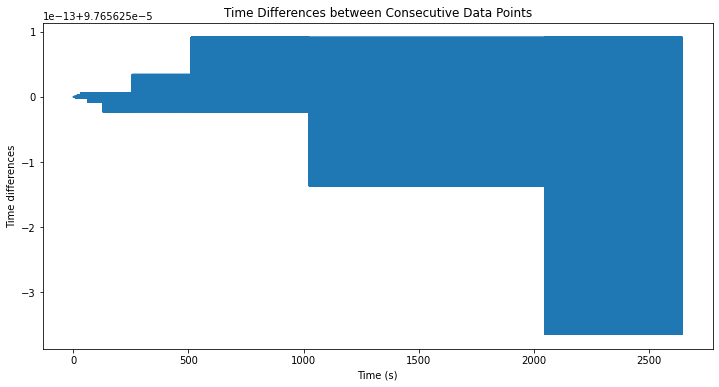

In [195]:
import matplotlib.pyplot as plt

# Remove the first value from time_values to match the length of time_differences
adjusted_time_values = time_values.iloc[1:]

plt.figure(figsize=(12, 6))
plt.plot(adjusted_time_values, time_differences)
plt.xlabel("Time (s)")
plt.ylabel("Time differences")
plt.title("Time Differences between Consecutive Data Points")
plt.show()

In [13]:
# Calculate the duration in seconds
start_time = data_frame.iloc[0, 0]
end_time = data_frame.iloc[-1, 0]
duration_seconds = end_time - start_time

# Get the file size in bytes
file_size_bytes = os.path.getsize(raw_test_name_1)*2

# Convert file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# Calculate disk space per second in megabytes
disk_space_per_second_mb = file_size_mb / duration_seconds

print(f"Disk space per second: {round(disk_space_per_second_mb,2)} MB/s")

print(f"Disk space per minute: {round(disk_space_per_second_mb*60,2)} MB/min")

print(f"Disk space per hour: {round(disk_space_per_second_mb*60*60/1024,2)} GB/hour")

Disk space per second: 1.19 MB/s
Disk space per minute: 71.28 MB/min
Disk space per hour: 4.18 GB/hour


# Signal

Plots a single channel against time. Note: To plot a full test length takes a significant amount of time

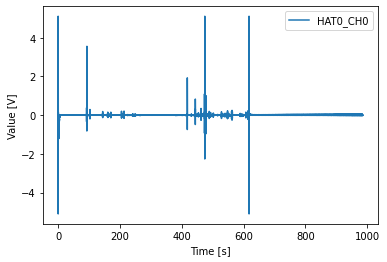

In [14]:
device_data = data_frame[["HAT0_CH0"]]

# Plot the first three columns with time_values as the x-axis
for column in device_data.columns:
    plt.plot(data_frame['time'], device_data[column], label=column)

#plt.xlim((1, 14))
#plt.ylim((-10, 11))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
#plt.title('D1 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()


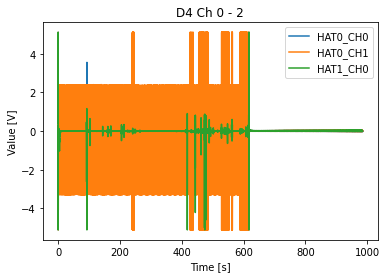

In [16]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["HAT0_CH0", "HAT0_CH1", "HAT1_CH0"]]

# Plot the first three columns with time_values as the x-axis
plt.plot(time_values, device_data)

#plt.xlim((45, 50))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()



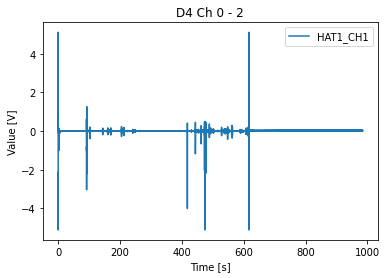

In [17]:
time_values = data_frame.iloc[:, 0]
device_data = data_frame[["HAT1_CH1"]]

# Plot the first three columns with time_values as the x-axis
plt.plot(time_values, device_data)

#plt.xlim((45, 50))
#plt.ylim((-2, 2))

# Customize the plot
plt.xlabel('Time [s]')
plt.ylabel('Value [V]')
plt.title('D4 Ch 0 - 2')
plt.legend(device_data.columns, loc='best')

# Show the plot
plt.show()



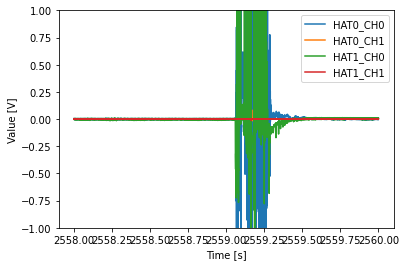

: 

In [220]:
def plot_data(data_frame, start=None, end=None):
    # Slice the data if start and end are provided
    if start is not None and end is not None:
        data_frame = data_frame[(data_frame['time'] >= start) & (data_frame['time'] <= end)]
    
    device_data = data_frame[["HAT0_CH0", "HAT0_CH1", "HAT1_CH0", "HAT1_CH1"]]

    # Plot the first three columns with time_values as the x-axis
    for column in device_data.columns:
        plt.plot(data_frame['time'], device_data[column], label=column)

    #plt.xlim((90, 115))
    plt.ylim((-1.0, 1.0))

    # Customize the plot
    plt.xlabel('Time [s]')
    plt.ylabel('Value [V]')
    #plt.title('D1 Ch 0 - 2')
    plt.legend(device_data.columns, loc='best')

    # Show the plot
    plt.show()

# You can call this function with start and end times like this:
plot_data(data_frame, start=2558, end=2560)
